# Continuous Environments
## Libraries used in notebook

In [1]:
import cv2
import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import PPO
from matplotlib import pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

## Introduction

In previous Notebook we explored the easiest variant of RL with discrete environment and a small number of states. To understand the next part we have to explain some theory we didn't cover before.

### Policies

When we talk about a **policy**, we are referring to the "behaviour" of the agent. In other words, given a state, what **action** should the agent take. A policy can be:
- **Deterministic**: always returns the same action for a given state;
- **Stochastic**: returns a probability distribution over actions.

In simpler, discrete environments, a policy can be represented as a table mapping states to actions. But in continuous environments with large or infinite state spaces, this becomes impossible - we need a way to **approximate** the Q-value or policy instead.

Here we also need to differentiate between **policy-based** and **value-based** methods.

### Value-based methods

In Q-learning, the agent learns a Q-function that estimates the expected **return value** of taking action $a$ in state $s$. In discrete cases, we used a Q-table to store this value. But in continuous environments, we can't store all possible combinations of states and actions - there are infinitely many.

To handle this, we approximate the Q-function using a **function approximator**, such as a **neural network**. This network takes a state (and possibly an action) as input and outputs an estimated Q-value.

Approximating the Q-function this way allows the agent to generalize across similar states - even if it has never seen a specific state before, it can make a reasonable guess based on what it has learned.

### Policy-based methods

Instead of learning a Q-function and deriving a policy from it, some algorithms aim to learn the policy **directly**. This is especially common in continuous action spaces, where finding the best action is hard or impossible.

In **policy-based methods**, we use a neural network (called the **policy network**) to approximate distribution over actions (not actions' return values). The network is trained to maximize expected reward, often using gradient-based techniques.

Some algorithms (like **actor-critic methods**) combine both approaches:
- The **actor** learns the policy (what to do),
- The **critic** learns the value function (how good it is).

## Introduction to algorithms from `stable-baselines3`

**Stable-baselines3** is an open source python library with implementations of reinforcement learning algorithms in PyTorch. It has well maintained [documentation](https://stable-baselines3.readthedocs.io/en/master/index.html) and we strongly recommend getting familiar with it.

The algorithms in `stable-baselines3` are ready to use however it's good to know how they work to easier choose their parameters. This section is based on the [Hugging Face RL Tutorial](https://huggingface.co/learn/deep-rl-course/unit0/introduction).

### Deep Reinforcement Learning

Before we talked about approximating either the Q-function or policy but what we really meant was **Deep Q-learning** and **Deep Reinforcement Learning**.

### Deep Q-Network (DQN)

Deep Q-Learning uses a deep neural network to approximate the different Q-values for each possible action at a state. To make it more stable the agents saves its experiences and learns from random samples of past events. It uses two networks - one that is used for learning and second - called the target network - that is updated less frequently to help stabilize learning.

### Advantage Actor Critic (A2C)

Advantage Actor Critic is a hybrid architecture, combining value- and policy-based methods. It uses:
- An *Actor* that controls **how the agent behaves** (policy-based method)
- A *Critic* that measures **how good the taken action is** (value-based method)

The *Advantage* in A2C refers to an advantage function that calculates the relative advantage of an action compared to the others possible at a state - **how taking that action at a state is better compared to the average value of the state**. If said action in better than the expected mean value the gradient is pushed in that direction, if it's worse - the opposite. In other words, it pushes the agent to take actions that lead to higher rewards and avoid harmful actions.

### Proximal Policy Optimization

Proximal Policy Optimization is similar to A2C except to improve the agent's training stability it avoids policy updates that are too large. To do so, it uses a ratio that indicates the difference between the current and old policy and clips this ratio to a specific range (hence the proximal policy term).


## Training with `stable-baselines3`
To showcase how to train an agent in continuous environment using `stable=baseline3` we'll use [LunarLanderContinuous-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/) from gymnasium library. The goal of the agent is to land a rocket on a landing pad controlling three engines.

![](https://gymnasium.farama.org/_images/lunar_lander.gif)

First we need to initialize the environment and learn the model.

In [2]:
env = gym.make(
    "LunarLanderContinuous-v3",
    continuous=True,
    render_mode="rgb_array"
)

env = Monitor(env)  # will be explained later

model = PPO("MlpPolicy", env)
model.learn(total_timesteps=10000, log_interval=10)

Now we can test and visualize the model. `determinictic` is set to `True` so that the model always chooses the best action. Make sure that you have both `gymnasium[box2d]` and `swig` installed.

In [3]:
obs, info = env.reset()
terminated = False
truncated = False

while not (terminated or truncated):
    action, _states = model.predict(obs, deterministic=True)
    next_state, reward, terminated, truncated, _ = env.step(action)
    frame = env.render()
    cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    cv2.waitKey(50)

cv2.destroyAllWindows()

The model did pretty badly because it uses the default parameters - in the next sections we'll show how to tune them.

## Evaluating models in `stable-baseline3`

Before we move to tuning hyperparameters first we need to know how to evaluate the model. There are many ways to do that both to see the performance during and after training.

### 1. Using `evaluate_policy()`

Instead of running many episodes manually after training, we can use [`evaluate_policy()`](https://stable-baselines3.readthedocs.io/en/master/common/evaluation.html) to automatically run multiple evaluation episodes and calculate the **mean and standard deviation of the rewards**:

In [4]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Mean reward: -149.16 ± 104.19


### 2. Using `EvalCallback`

`EvalCallback` evaluates the model every `eval_freq` steps and saves the best-performing model basen on mean reward:

In [5]:
env = gym.make("LunarLanderContinuous-v3")
env = Monitor(env)

eval_callback = EvalCallback(
    env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=10000,
    n_eval_episodes=5,
    deterministic=True,
    render=False,
)

model = PPO("MlpPolicy", env)
model.learn(total_timesteps=100000, callback=eval_callback)

Eval num_timesteps=10000, episode_reward=-139.94 +/- 79.98
Episode length: 121.60 +/- 18.26
New best mean reward!
Eval num_timesteps=20000, episode_reward=-83.82 +/- 151.73
Episode length: 182.40 +/- 94.59
New best mean reward!
Eval num_timesteps=30000, episode_reward=-34.83 +/- 129.61
Episode length: 520.40 +/- 246.83
New best mean reward!
Eval num_timesteps=40000, episode_reward=-243.15 +/- 16.90
Episode length: 369.40 +/- 97.97
Eval num_timesteps=50000, episode_reward=-195.38 +/- 37.26
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=-134.88 +/- 62.69
Episode length: 830.40 +/- 152.01
Eval num_timesteps=70000, episode_reward=-59.77 +/- 13.35
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=-30.21 +/- 58.24
Episode length: 977.60 +/- 32.65
New best mean reward!
Eval num_timesteps=90000, episode_reward=47.03 +/- 96.08
Episode length: 862.40 +/- 89.97
New best mean reward!
Eval num_timesteps=100000, episode_reward=101.78 +/- 150.73
Epis

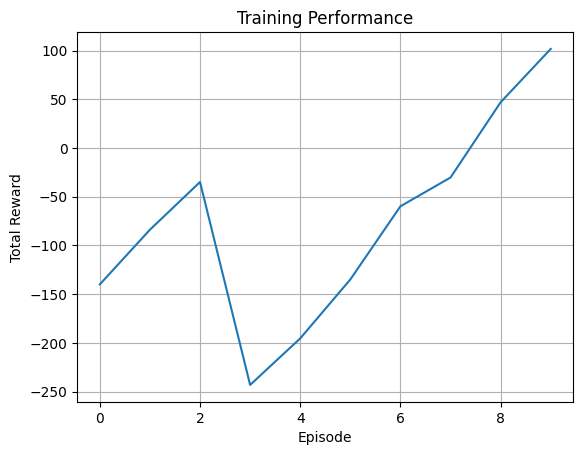

In [6]:
data = np.load("./logs/evaluations.npz")
mean_rewards = data["results"].mean(axis=1)
plt.plot(mean_rewards)
plt.title("Training Performance")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)

### 3. Using a `Monitor` wrapper

`Monitor` is a wrapper that records episode-level data:
- Episode **reward**
- Episode **length**
- Time taken

Which can be later used to plot rewards manually. It also has to be used when using `evaluate_policy() or `EvalCallback`:


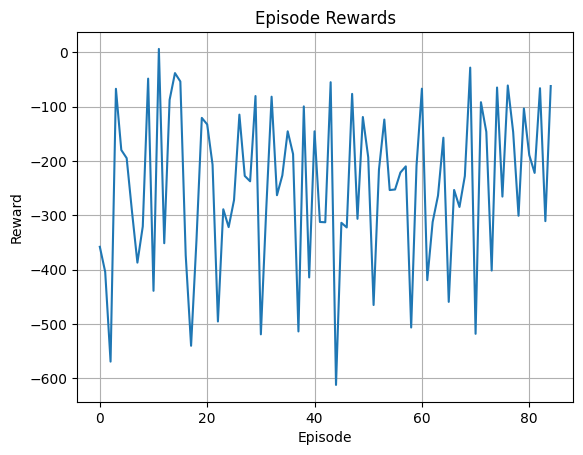

In [7]:
env = gym.make("LunarLanderContinuous-v3")
env = Monitor(env, filename="./logs/monitor.csv")

model = PPO("MlpPolicy", env)
model.learn(total_timesteps=10000, log_interval=10)

data = pd.read_csv("./logs/monitor.csv", skiprows=1)

plt.plot(data["r"])
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

###  4. Using `tensorboard_log`

When you pass a `tensorboard_log` path to your model, it automatically logs:
- Episode rewards
- Value loss, policy loss, entropy, etc.
- Timesteps, learning rate, etc.

You can view it by running in terminal:

```
tensorboard --logdir=./logs/ppo_tensorboard/
```

And opening the link (usually http://localhost:6006/)

In [8]:
env = gym.make("LunarLanderContinuous-v3")

model = PPO("MlpPolicy", env, tensorboard_log="./logs/ppo_tensorboard/")
model.learn(total_timesteps=10000)

## Tuning hyperparameters
Finally, we can move to tuning the hyperparameters. In the [documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) you can check all parameters both for all models and specific to PPO.

Below is a description of the most important parameters and how they influence training:

| Hyperparameter  | Description                                                             | Typical Values   |
|-----------------|-------------------------------------------------------------------------|------------------|
| `learning_rate` | Step size for updating model weights. Smaller = slower but more stable. | `1e-5` to `1e-3` |
| `n_steps`       | Number of steps to collect before each policy update.                   | 128, 256, 512    |
| `batch_size`    | Minibatch size for updates. Should divide `n_steps * n_envs` evenly.    | 64, 128, 256     |
| `n_epochs`      | How many times each minibatch is used per update.                       | 4–10             |
| `gamma`         | Discount factor for future rewards. Closer to 1 = long-term focus.      | 0.95–0.999       |
| `gae_lambda`    | GAE smoothing. Controls bias-variance tradeoff in advantage estimation. | 0.9–0.98         |
| `clip_range`    | Clipping parameter to limit policy updates and improve stability.       | 0.1–0.3          |
| `ent_coef`      | Coefficient for entropy bonus to encourage exploration.                 | 0.0–0.01         |

## Evaluation with tuned parameters showcase

First we need to make the environment:

In [9]:
env = gym.make("LunarLanderContinuous-v3", render_mode="rgb_array")
env = Monitor(env, filename="./logs/monitor_final")

Then we'll make the EvalCallback to store the performance during training:

In [10]:
eval_callback = EvalCallback(
    env,
    best_model_save_path="./logs/final_model",
    log_path="./logs/final_model",
    eval_freq=10000,
    n_eval_episodes=5,
    deterministic=True,
    render=False,
)

Now it's time for training:

In [11]:
model = PPO(
    "MlpPolicy",
    env,
    n_steps=1024,
    batch_size=64,
    gae_lambda=0.98,
    gamma=0.999,
    n_epochs=4,
    ent_coef=0.01,
    verbose=1,
    tensorboard_log="./logs/final_tensorboard/"
)

model.learn(total_timesteps=300000, callback=eval_callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/final_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 105      |
|    ep_rew_mean     | -294     |
| time/              |          |
|    fps             | 1353     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 105          |
|    ep_rew_mean          | -249         |
| time/                   |              |
|    fps                  | 1187         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0013294818 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    en

We can evaluate the model with `eval_policy`:

In [12]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Final model mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Final model mean reward: 158.41 ± 83.74


Plotting the learning curves:

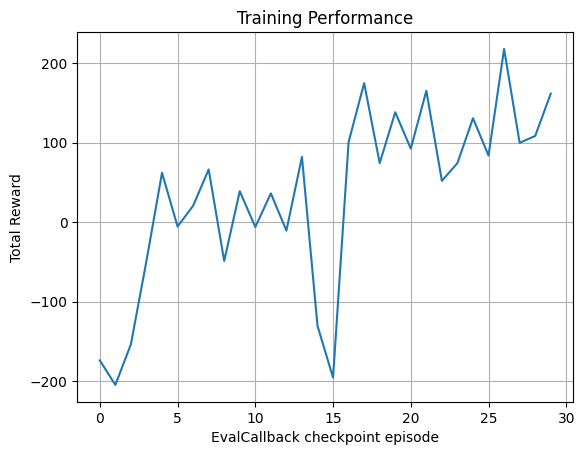

In [13]:
eval_data = np.load("./logs/final_model/evaluations.npz")
mean_rewards = eval_data["results"].mean(axis=1)
plt.figure()
plt.plot(mean_rewards)
plt.title("Training Performance")
plt.xlabel("EvalCallback checkpoint episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

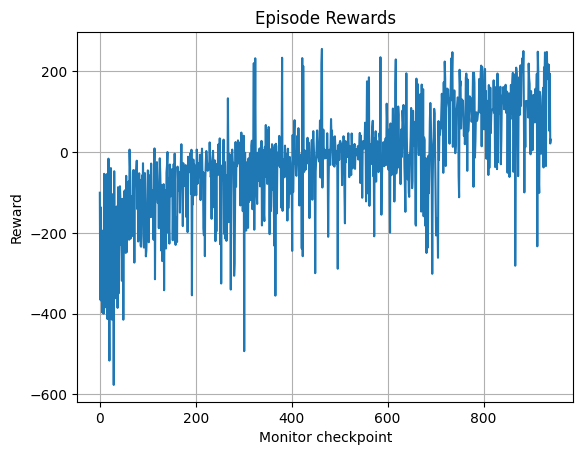

In [15]:
monitor_data = pd.read_csv("./logs/monitor_final.monitor.csv", skiprows=1)
episode_rewards = monitor_data["r"]
plt.figure()
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Monitor checkpoint")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

In [18]:
obs, info = env.reset()
terminated = False
truncated = False

while not (terminated or truncated):
    action, _states = model.predict(obs, deterministic=True)
    next_state, reward, terminated, truncated, _ = env.step(action)
    frame = env.render()
    cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    cv2.waitKey(50)

cv2.destroyAllWindows()

For most gym environments you can check the best hyperparameters in the [RL Baselines3 Zoo GitHub page](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml). It's a training framework for RL. We won't cover it in this Notebook, but we recommend checking out the [documentation](https://rl-baselines3-zoo.readthedocs.io/en/master/). Another great framework for tuning parameters is [Optuna](https://optuna.org/), for which `stable-baselines` provides a built-in integration.



## Conclusion

In this Notebook, we explored **reinforcement learning with continuous action spaces** using `stable-baselines3`, various Deep RL algorithms, evaluating models and tuning hyperparameters. The next step will be learning about Multi-Agent RL.